In [1]:
from stylelib import *
from process_helper import *

In [2]:
path = "/Users/scarlet/Downloads/Sundial-Private/outputs/"
paper_path = "revision/"
storage = "redis"
selectby = "median"
unit = "ms"

## 0. Select Color Scheme

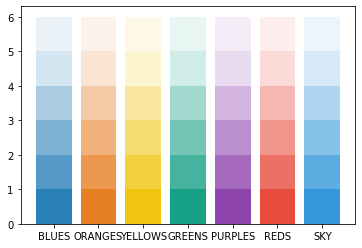

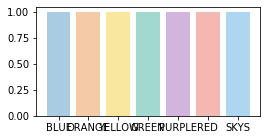

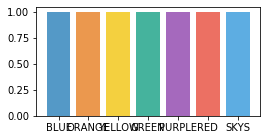

<Figure size 288x144 with 0 Axes>

In [3]:
_, grad_colors = display_colors()
_, bar_colors = select_color_idx(2)
_, line_colors = select_color_idx(4)

In [4]:
C_1PC

'ORANGE'

In [5]:
C_2PC

'BLUE'

In [6]:
C_CL = "PURPLE"

In [8]:
plt.rcParams.update({'font.size': 18})
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5

In [7]:
# df1 = pd.read_csv(path+"num_nodes_cl_only.csv")
# print(df1.shape)
# df2 = pd.read_csv(path+"num_nodes_cl.csv")
# df2 = apply_mask(df, [("COMMIT_ALG", "COORDINATOR_LOG", "ne")])
# print(df2.shape)
# df = pd.concat([df1, df2], axis=0, sort=False)
# df = df[df["99%_dist_latency"] < 10]
df = pd.read_csv(path+"num_nodes_cl_newredis.csv")
print(df.shape)

(160, 222)


In [8]:
df.columns.values

array(['DISTRIBUTED', 'NUM_WORKER_THREADS', 'NUM_RPC_SERVER_THREADS',
       'MAX_NUM_ACTIVE_TXNS', 'CC_ALG', 'COMMIT_ALG', 'LOG_DEVICE', 'i',
       'RUN_TIME', 'LOG_DELAY', 'WORKLOAD', 'NUM_NODES', 'PERC_REMOTE',
       'READ_PERC', 'ZIPF_THETA', 'SYNTH_TABLE_SIZE', 'FAILURE_ENABLE',
       'MODE', 'EXP_ID', 'NODE_TYPE', 'NODE_ID', 'Throughput', 'run_time',
       'dist_txn_latency', 'time_process_txn', 'time_idle',
       'time_write_output_queue', 'log_size', 'bytes_sent',
       'dummy_bytes_sent', 'time_send_msg', 'time_read_queue',
       'time_output_idle', 'bytes_received', 'time_recv_msg',
       'time_write_queue', 'time_input_idle', 'logging_send_time',
       'logging_commit_time', 'single_part_execute_phase (in us)',
       'single_part_precommit_phase (in us)',
       'single_part_log_latency (in us)',
       'single_part_commit_phase (in us)', 'single_part_abort (in us)',
       'multi_part_execute_phase (in us)',
       'multi_part_precommit_phase (in us)',
       'mul

In [9]:
df.groupby(["NUM_NODES", "COMMIT_ALG"])["average_node_communicate"].median()

NUM_NODES  COMMIT_ALG     
2          COORDINATOR_LOG    627.1820
           ONE_PC             580.4520
           TWO_PC             616.8930
4          COORDINATOR_LOG    561.8640
           ONE_PC             615.5000
           TWO_PC             575.2740
6          COORDINATOR_LOG    541.5495
           ONE_PC             553.6980
           TWO_PC             553.6780
8          COORDINATOR_LOG    520.0725
           ONE_PC             567.5665
           TWO_PC             483.8600
Name: average_node_communicate, dtype: float64

In [10]:
df.groupby(["NUM_NODES", "COMMIT_ALG"])["average_log_sync_data"].median()

NUM_NODES  COMMIT_ALG     
2          COORDINATOR_LOG    480728.5
           ONE_PC             571105.0
           TWO_PC             506783.5
4          COORDINATOR_LOG    501644.5
           ONE_PC             758787.5
           TWO_PC             671546.0
6          COORDINATOR_LOG    490812.5
           ONE_PC             781255.0
           TWO_PC             707916.0
8          COORDINATOR_LOG    494551.5
           ONE_PC             799957.0
           TWO_PC             750013.5
Name: average_log_sync_data, dtype: float64

## Coordinator Log

In [11]:
exp = "num_nodes_cl_%s"%storage
x = "NUM_NODES"
# agg: "latency" or "Throughput"
agg_throughput, agg_latency = aggregate(x, df, latency_type="dist_latency", agg="latency", how="median")
agg_multi_latency = process_latency(x, df, latency_type="multi_part_latency", select=agg_latency)

selected trial with median AGG_average_dist_latency


In [12]:
agg_latency

AGG_99%_dist_latency  AGG_average_dist_latency       COMMIT_ALG  \
0               0.245865                  0.164701  COORDINATOR_LOG   
5               0.249786                  0.164319  COORDINATOR_LOG   
2               0.251454                  0.165044  COORDINATOR_LOG   
7               0.253603                  0.163931  COORDINATOR_LOG   
18              0.134142                  0.110721           ONE_PC   
12              0.124933                  0.104456           ONE_PC   
16              0.147421                  0.113108           ONE_PC   
13              0.136155                  0.109342           ONE_PC   
21              0.251290                  0.204520           TWO_PC   
26              0.256330                  0.207924           TWO_PC   
31              0.254852                  0.210536           TWO_PC   
24              0.267102                  0.217631           TWO_PC   

    NUM_NODES  i  
0           2  0  
5           4  1  
2           6  0  
7           8  1  
18          2  2  
12          4  0  
16          6  1  
13          8  0  
21          2  0  
26          4  1  
31          6  2  
24          8  0

In [1]:
0.163931 / 0.109342

1.4992500594465072

In [2]:
0.217631 / 0.163931

1.3275768463560889

### 2) Latency

In [33]:
def plot_latency(x, data, ys=y_agg_latency, fig=None, ax=None, xlabel="", prefix=PREFIX, ylim=1.5, 
                 line_colors=BLUES, width=5, unit="ms", ylim_speedup=1.5, 
                 plot_speedup=False, speedup_format="text", speedup_yspace=5, speedup_xspace=-1):
    linestyle = ["-", "--"] # avg, tail
    if fig is None:
        fig, ax = plt.subplots()
    marker = ["^", "o", "s"] # 1pc, 2pc
    color = [line_colors[C_1PC], line_colors[C_2PC], line_colors[C_CL]]
    alglabel = ["Cornus", "2PC", "Coordinator Log"]
    scale = 1
    if unit == "ms":
        scale = 1000
    elif unit == "us":
        scale = 1000000    
    ymax = 0
    for i, alg in enumerate(["ONE_PC", "TWO_PC", "COORDINATOR_LOG"]):
        y_data = data[data['COMMIT_ALG'] == alg].sort_values(by=x)
        for j, y in enumerate(ys):
            # default unit is second
            y_data[prefix+y] = y_data[prefix+y] * scale
            ymax = max(y_data[prefix+y].max(), ymax)
            ax.plot(x, prefix+y, marker=marker[i], data=y_data, linestyle=linestyle[j], 
                    label=alglabel[i] + " "+ y.replace('_',' '), color=color[i])
    ax.legend(["Cornus avg", "Cornus 99%", "2PC avg", "2PC 99%", "CL avg", "CL 99%"],
              loc='upper left', ncol=3, labelspacing=0.1, prop={'size': 18},
              columnspacing=0.2, handletextpad=0.1, frameon=False, bbox_to_anchor=(-0.2,1.35))
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Distributed Txn\n Latency ({})".format(unit))
    plt.grid(axis='y', linestyle='--', linewidth=0.35)
    fig.set_size_inches(6, 3)
    return fig, ax

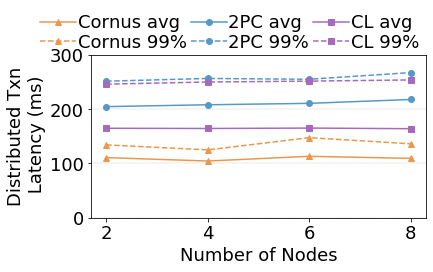

In [35]:
x = "NUM_NODES"

data = agg_latency.sort_values(by=x)
fig, ax = plot_latency(x, data, ys=y_agg_dist_latency, 
                            xlabel="Number of Nodes",
                            plot_speedup=False, speedup_yspace=10, speedup_xspace=-0.05,
                            line_colors=line_colors, ylim=1.1, unit="ms")
plt.ylim((0, 300))
#ax.set_ylabel("Distributed Txn\n Tail Latency\n(%s)"%unit)
plt.savefig(paper_path+exp+"_latency_({}_latency).pdf".format(selectby), bbox_inches="tight")

### 3) breakdown

In [57]:
def plot_1breakdown(x, zipper, xcategories, bar_colors, grad_colors, how="max", agg_multi_latency=None, ax=None, fig=None,
                   extra_legend=True, unit="ms", ylim=1.5):
    if ax is None:
        fig, ax = plt.subplots()
    color_patches = [bar_colors[c] for c in [C_1PC, C_2PC, "PURPLE"]]
    color = [grad_colors[C_1PC+"S"], grad_colors[C_2PC+"S"], grad_colors["PURPLES"]]
    pattern = ALL_PATTERNS
    offset = [-0.1, 0, 0.1]
    
    for idx, (d, ys) in enumerate(zipper):
        if how == "max":
            data = apply_mask(d, [(x, d[x].max())])
        else:
            data = apply_mask(agg_multi_latency, [(x, d)])
        for j, alg in enumerate(["ONE_PC", "TWO_PC", "COORDINATOR_LOG"]):
            bottom = 0
            plot_data = apply_mask(data, [("COMMIT_ALG", alg)])
            for i, y in enumerate(ys):
                v = plot_data[PREFIX+y].values
                if unit == "ms":
                    v = v / 1000
                elif unit == "s":
                    v = v / 1000000
                p = ax.bar(idx/2.0+offset[j], v, bottom=bottom, width=0.1, 
                           color=color[j][i], hatch=pattern[i], edgecolor='black')
                bottom += v

    plt.grid(axis='y', linestyle='--', linewidth=0.35)
    if extra_legend:
        legend2 = plt.legend(get_color_patches(["1PC", "2PC", ""], color_patches), 
                             ["Cornus (left)", "2PC", "CL (right)"], 
                             loc="upper left", bbox_to_anchor=((-0.3,1.3)), ncol=3, frameon=False,
                             prop={'size': 18}, columnspacing=0.5, handletextpad=0.2)
        plt.gca().add_artist(legend2)
    labels = ["execution", "prepare", "commit", "abort"]
    ax.legend(get_pattern_patches(labels, pattern), labels,prop={'size': 18}, 
              loc='upper left', ncol=2, labelspacing=0.1, 
              columnspacing=0.5, handletextpad=0.5, frameon=False, bbox_to_anchor=((-0,1.1)))
    ax.set_xlabel("Txn Type")
    ax.set_ylabel("Latency Breakdown\n(%s)"%unit)
    plt.ylim(0, bottom.max()*ylim)
    plt.xticks(np.arange(0, len(xcategories)*0.5, 0.5), xcategories)
    fig.set_size_inches(5, 2.5)
    return fig, ax

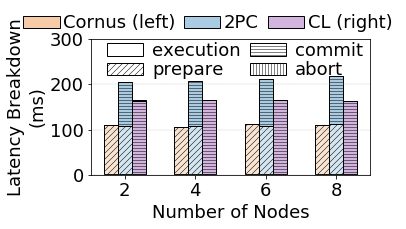

In [58]:
xcate = data[x].unique()
zipper = zip(xcate, [y_multi_part_latency]*len(xcate))
fig, ax = plot_1breakdown(x, zipper, xcate, bar_colors, grad_colors, 
                          how=None, agg_multi_latency=agg_multi_latency, ylim=1.1)
#plt.xticks(np.array([0, 1, 2, 3]), xcate)
#ax.set_yscale('log')
ax.set_ylim((0, 300))
ax.set_xlabel("Number of Nodes")
plt.savefig(paper_path+exp+"_latency({}).pdf".format(selectby), bbox_inches="tight")